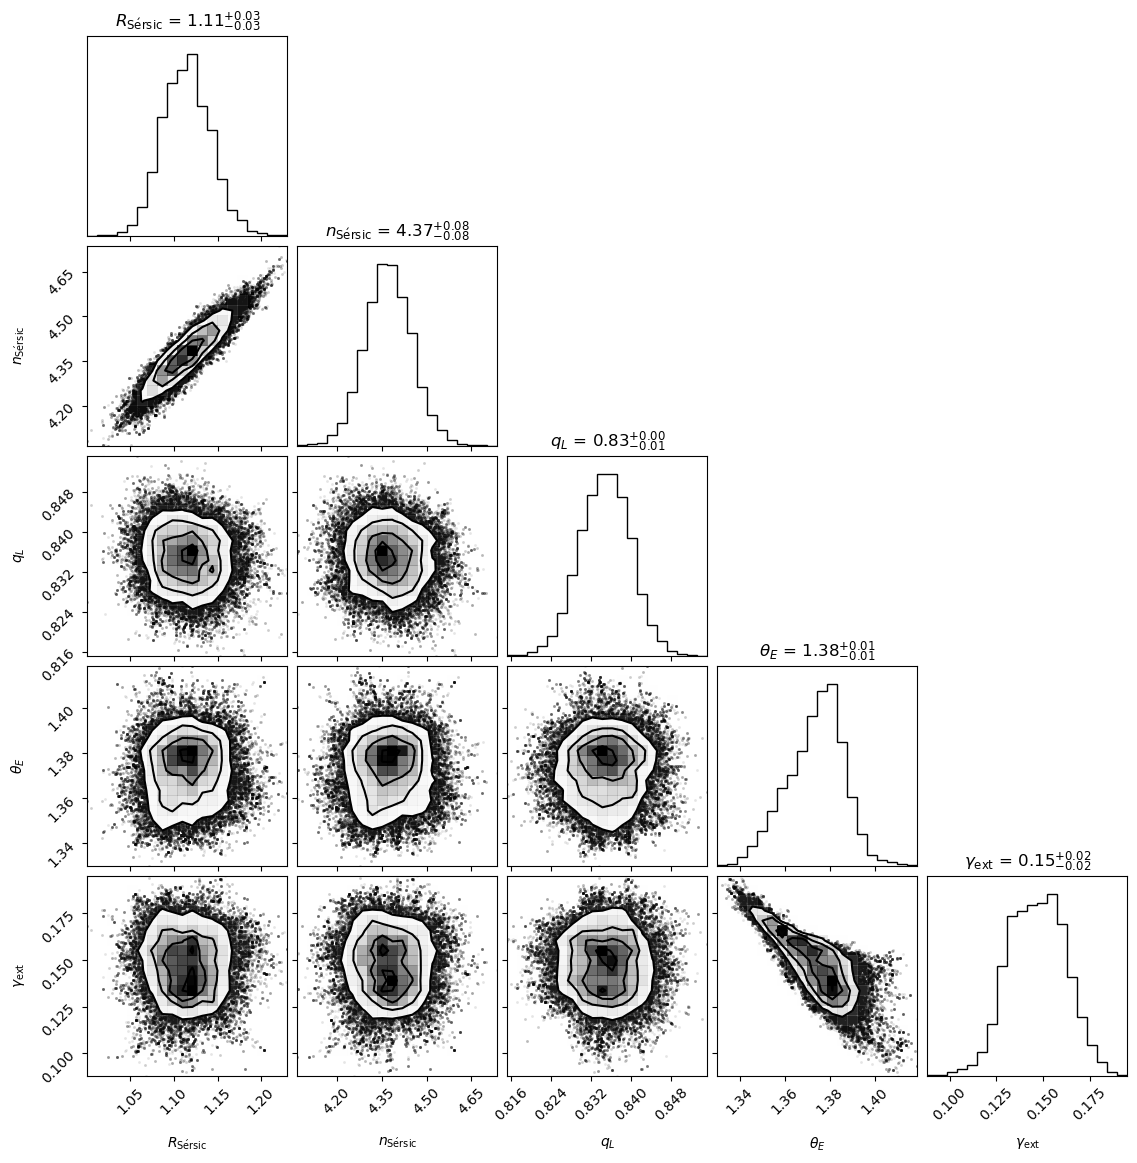

In [ ]:
import pickle
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Plots import chain_plot
from lenstronomy.Workflow.fitting_sequence import FittingSequence
import h5py
import corner
import numpy as np
import matplotlib.pyplot as plt

name = "J2325-5229"
filter = "F814W"
filename = f"../cutout_data/{name}/{filter}/{name}_{filter}.pkl"

# Load the saved data
with open(filename, "rb") as f:
    loaded_data = pickle.load(f)

kwargs_result = loaded_data["kwargs_result"]
multi_band_list = loaded_data["multi_band_list"]
kwargs_model = loaded_data["kwargs_model"]
kwargs_params = loaded_data.get("kwargs_params", None)
chain_list = loaded_data.get('chain_list')
kwargs_constraints = loaded_data.get("kwargs_constraints", None)
kwargs_likelihood = loaded_data.get("kwargs_likelihood", None)
kwargs_data_joint = loaded_data.get("kwargs_data_joint", None)

fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

# Get MCMC samples
sampler_type, samples_mcmc, param_mcmc, dist_mcmc = chain_list[1]

# Indices of desired parameters
param_names = ['R_sersic_lens_light0', 'n_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'theta_E_lens0',
                'gamma1_lens1', 'gamma2_lens1']
indices = [param_mcmc.index(p) for p in param_names]

# Extract chains
r_sersic = samples_mcmc[:, indices[0]]
n_sersic = samples_mcmc[:, indices[1]]
e1 = samples_mcmc[:, indices[2]]
e2 = samples_mcmc[:, indices[3]]
theta_E = samples_mcmc[:, indices[4]]
gamma1_chain = samples_mcmc[:, indices[5]]
gamma2_chain = samples_mcmc[:, indices[6]]

# Compute ellipticity and convert to axis ratio q
e = np.sqrt(e1**2 + e2**2)
q = (1 - e) / (1 + e)

gamma_chain = np.sqrt(gamma1_chain**2 + gamma2_chain**2)

samples_corner = np.vstack([r_sersic, n_sersic, q, theta_E, gamma_chain]).T
labels_corner = [r'$R_{\mathrm{S\'ersic}}$', r'$n_{\mathrm{S\'ersic}}$', r'$q_L$', r'$\theta_E$', r'$\gamma_{\text{ext}}$']

# Plot
fig = corner.corner(samples_corner, labels=labels_corner, show_titles=True)
plt.show()


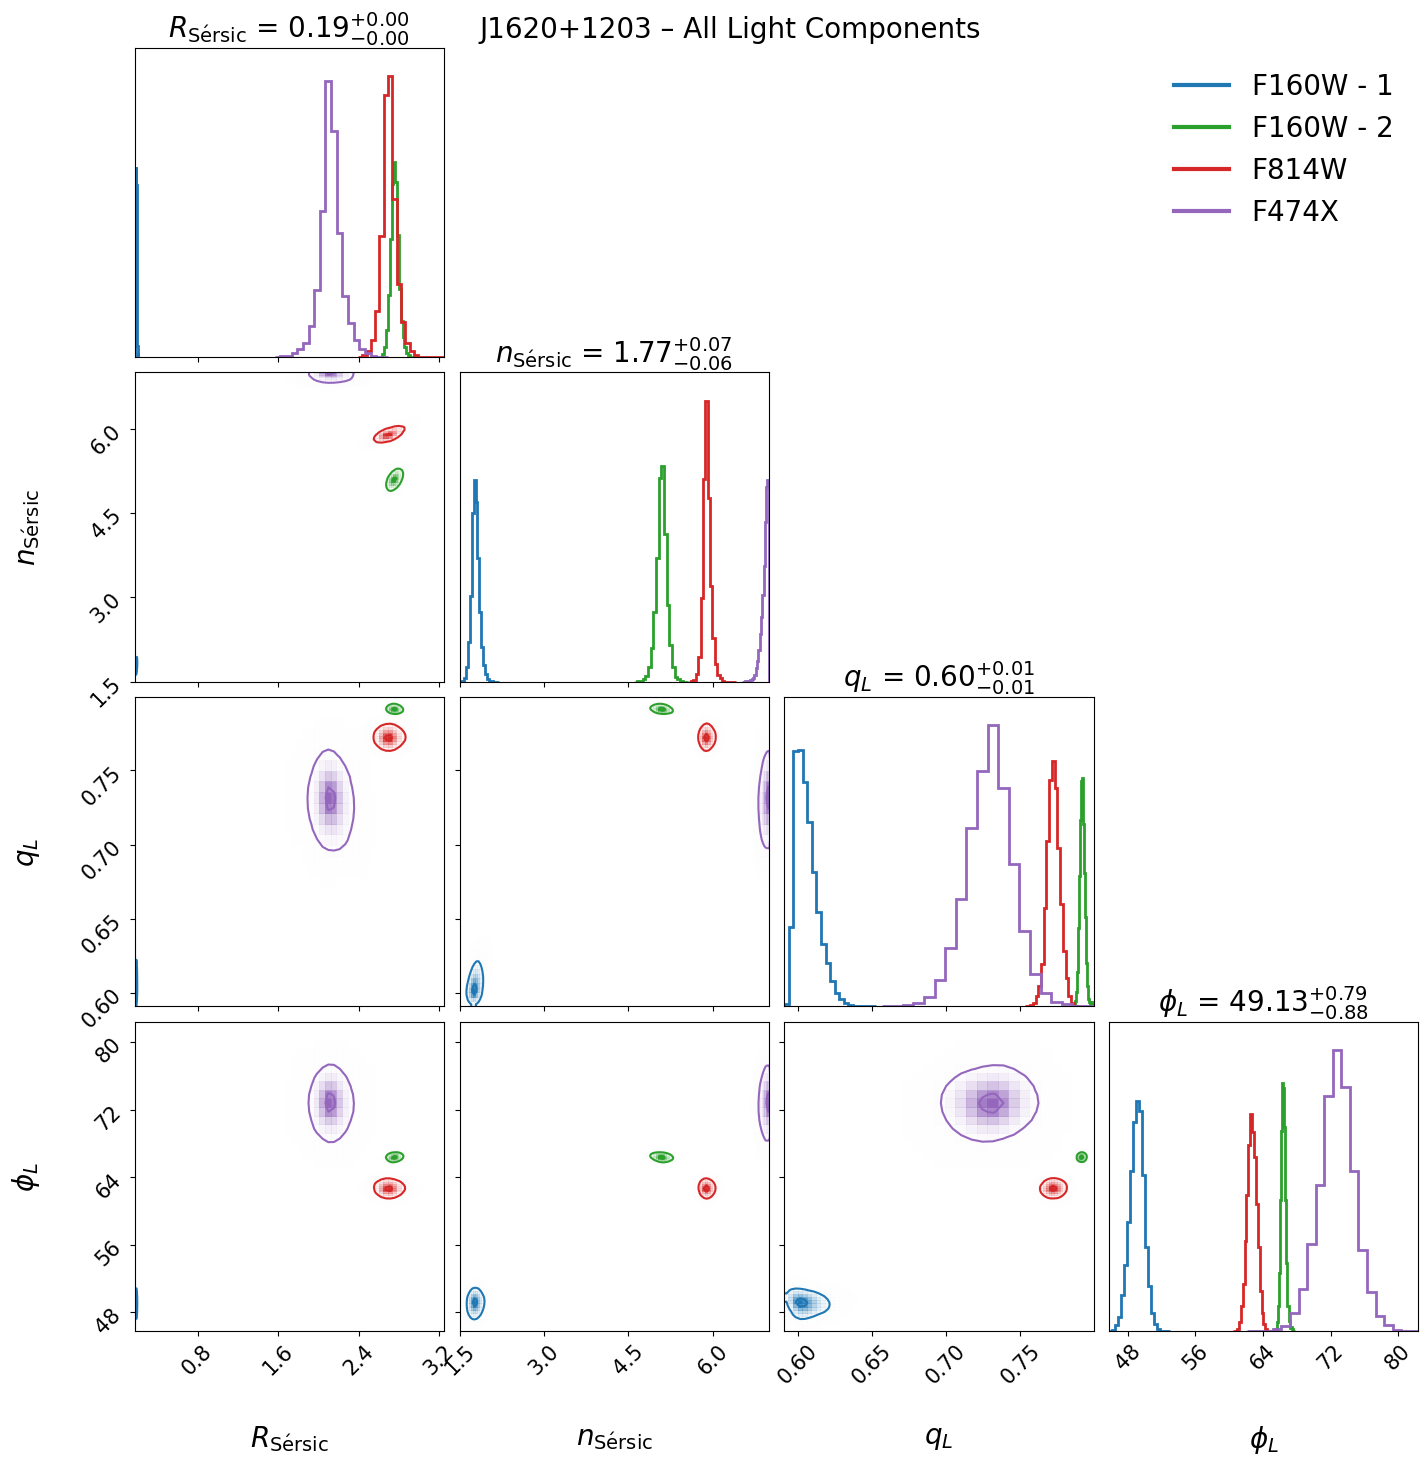

In [30]:
import pickle
import numpy as np
import corner
import matplotlib.pyplot as plt
from lenstronomy.Workflow.fitting_sequence import FittingSequence

# --- Load Data ---
name = "J1620+1203"
filename = f"../joint_modeling/{name}/{name}_joint.pkl"

with open(filename, "rb") as f:
    loaded_data = pickle.load(f)

kwargs_result = loaded_data["kwargs_result"]
kwargs_model = loaded_data["kwargs_model"]
kwargs_params = loaded_data.get("kwargs_params", None)
chain_list = loaded_data.get('chain_list')
kwargs_constraints = loaded_data.get("kwargs_constraints", None)
kwargs_likelihood = loaded_data.get("kwargs_likelihood", None)
kwargs_data_joint = loaded_data.get("kwargs_data_joint", None)

fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

# --- MCMC Samples ---
sampler_type, samples_mcmc, param_mcmc, dist_mcmc = chain_list[3]

def compute_q(e1, e2):
    e = np.sqrt(e1**2 + e2**2)
    q = (1 - e) / (1 + e)
    return q

def compute_phi(e1, e2):
    return 0.5 * np.arctan2(e2, e1) * 180 / np.pi

# --- Find all Sersic profiles automatically ---
sersic_components = []
for p in param_mcmc:
    if "R_sersic_lens_light" in p:
        idx = p.split("lens_light")[-1]
        if idx.isdigit() and int(idx) not in sersic_components:
            sersic_components.append(int(idx))
sersic_components.sort()

# --- Define colors for each component ---
colors = ["#1f77b4", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2"]  # blue, green, red, purple, brown, pink

# --- Prepare corner plot ---
labels_corner = [
    r"$R_{\mathrm{S\'ersic}}$",
    r"$n_{\mathrm{S\'ersic}}$",
    r"$q_L$",
    r"$\phi_L$"
]

fig = None

# --- Loop over components and overlay ---
for i, comp in enumerate(sersic_components):
    try:
        param_names = [
            f"R_sersic_lens_light{comp}",
            f"n_sersic_lens_light{comp}",
            f"e1_lens_light{comp}",
            f"e2_lens_light{comp}",
        ]
        indices = [param_mcmc.index(p) for p in param_names]

        r_sersic = samples_mcmc[:, indices[0]]
        n_sersic = samples_mcmc[:, indices[1]]
        e1 = samples_mcmc[:, indices[2]]
        e2 = samples_mcmc[:, indices[3]]
        q = compute_q(e1, e2)
        phi = compute_phi(e1, e2)

        samples_corner = np.vstack([r_sersic, n_sersic, q, phi]).T

        fig = corner.corner(
            samples_corner,
            fig=fig,
            color=colors[i % len(colors)],
            labels=labels_corner if i == 0 else None,
            show_titles=True if i == 0 else False,
            title_fmt=".2f",
            smooth=1.0,
            levels=(0.16, 0.84),
            plot_density=True,
            fill_contours=False,
            plot_datapoints=False,
            contour_kwargs={"colors": [colors[i % len(colors)]]},
            hist_kwargs={"color": colors[i % len(colors)], "linewidth": 2},
            title_kwargs={"fontsize": 20},
            label_kwargs={"fontsize": 20}
        )
    except ValueError as e: print(f"⚠️ Skipped lens_light{comp}: missing parameter ({e})")
# --- Add legend manually ---
labels = ['F160W - 1', 'F160W - 2', 'F814W', 'F474X']

handles = [
    plt.Line2D([], [], color=colors[i], lw=3, label=labels[i])
    for i in range(len(labels))
]

fig.axes[3].legend(handles=handles, loc="upper right", fontsize=20, frameon=False)
# Increase tick label size
for ax in fig.get_axes():
    ax.tick_params(axis='both', labelsize=15)

fig.set_size_inches(15, 15)
plt.suptitle(f"{name} – All Light Components", fontsize=20)
#plt.savefig(f"{name}_all_lens_lights_corner.png", bbox_inches="tight", dpi=200)
plt.show()
